# Route Generator

## Inputs
- File containing the road network
- File containing the link parameters such as travel time, waiting time, toll fare.
- File containing the position, destination for each agent
- File containing the agent parameters

## Outputs
- File containing plans for all agents with scores

In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import random
import os

%matplotlib inline

### Helper Functions

In [2]:
def drawNetwork(G):
    '''
    Helper function to plot the network for visualization
    
    Return values:
        G - road network as a networkx graph
    '''
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(12, 12))    
    nx.draw(G,pos,labels={node:node for node in G.nodes()},node_color='g')
    edge_labels = {
        (a,b):
        "%.2f" % round(nx.get_edge_attributes(G,'p_1')[(a,b) if a<b else (b,a)],2) + ', ' +
        "%.2f" % round(nx.get_edge_attributes(G,'p_2')[(a,b) if a<b else (b,a)],2) + ', ' +
        "%.2f" % round(nx.get_edge_attributes(G,'p_3')[(a,b) if a<b else (b,a)],2) + ', ' +
        "%.2f" % round(nx.get_edge_attributes(G,'p_4')[(a,b) if a<b else (b,a)],2) + '\n' +
        "%.2f" % round(nx.get_edge_attributes(G,'p_1')[(a,b) if a>b else (b,a)],2) + ', ' +
        "%.2f" % round(nx.get_edge_attributes(G,'p_2')[(a,b) if a>b else (b,a)],2) + ', ' +
        "%.2f" % round(nx.get_edge_attributes(G,'p_3')[(a,b) if a>b else (b,a)],2) + ', ' +
        "%.2f" % round(nx.get_edge_attributes(G,'p_4')[(a,b) if a>b else (b,a)],2)
        for a,b in G.edges()}
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_color='r')
    plt.axis('off')
    plt.show()

### Parameters

In [3]:
n_params = 4 # No. of link parameters

# Temporary Parameters
N = 4 # No. of rows in grid
M = 5 # No. of cols in grid
n_agents = 40 # No. of agents to generate plans

### Core Functionality

In [4]:
def getNetworkFromFile(path):
    '''
    Creates a network using the networkx library using the file containing the road network
    
    Parameters:
        path    - path to input file containing road network
    
    Return values:
        G       - graph of networkx which contains the road network 
        n_nodes - number of nodes read
    '''
    
    # TODO: Instead of making network, read from file
    
    global N,M
    
    G = nx.DiGraph()
    
    # Adding N*M nodes to graph
    for i in range(N*M):
        # These positions are only for visualization since (0,0) is 
        # on the bottom left side
        G.add_node(str(i+1),pos=(i%M+1,4-int(i/M)))
        
    n_nodes = N*M
    
    return G, n_nodes

In [5]:
def getNetworkWithLinkParameters(G, path):
    '''
    Adds the link parameters (waiting time, travel time, etc to the road network)
    
    Parameters:
        G       - input road network as a networkx graph
        path    - path to input file containing network parameters
        
    Return values:
        G       - road network with parameters added
        n_links - number of links read
    '''
    
    # TODO: Read this dict from file
    
    
    global N,M,n_params
    
    # Temporarily using normal distribution (1,0.2) and 4 parameters 
    
    link_idx = 0;
    
    # All nodes will have an edge to the node on their right side
    # except the last column
    for i in range(N):
        for j in range(M-1):
            G.add_edge(str(M*i+j+1), str(M*i+j+2),
                        link_id = link_idx+1, 
                        p_1=np.random.normal(1,0.2),
                        p_2=np.random.normal(1,0.2),
                        p_3=np.random.normal(1,0.2),
                        p_4=np.random.normal(1,0.2))
            link_idx = link_idx + 1
    
    # All nodes will have an edge to the node on their left side
    # except the first column
    for i in range(N):
        for j in range(1,M):
            G.add_edge(str(M*i+j+1), str(M*i+j), 
                        link_id = link_idx+1,  
                        p_1=np.random.normal(1,0.2),
                        p_2=np.random.normal(1,0.2),
                        p_3=np.random.normal(1,0.2),
                        p_4=np.random.normal(1,0.2))
            link_idx = link_idx + 1
            
    # All nodes will have an edge to the node on their bottom side
    # except the last row
    for i in range(N-1):
        for j in range(M):
            G.add_edge(str(M*i + j+1), str(M*(i+1)+j+1), 
                        link_id = link_idx+1, 
                        p_1=np.random.normal(1,0.2),
                        p_2=np.random.normal(1,0.2),
                        p_3=np.random.normal(1,0.2),
                        p_4=np.random.normal(1,0.2))
            link_idx = link_idx + 1
            
    # All nodes will have an edge to the node on their top side
    # except the first row
    for i in range(1,N):
        for j in range(M):
            G.add_edge(str(M*i + j+1), str(M*(i-1)+j+1), 
                        link_id = link_idx+1,  
                        p_1=np.random.normal(1,0.2),
                        p_2=np.random.normal(1,0.2),
                        p_3=np.random.normal(1,0.2),
                        p_4=np.random.normal(1,0.2))
            link_idx = link_idx + 1
            
    n_links = link_idx
    
    return G, n_links

In [6]:
def getAgentPreferencesFromFile(path):
    '''
    Read preferences of all agents from file
    
    Parameters:
        path        - path to input file containing preferences
        
    Return values:
        agent_prefs - dict containing preferences for each agents
        n_prefs     - no of preferences read
    '''
    
    # TODO: Read from file
    
    global n_agents
    
    prefs = {}
    
    for i in range(n_agents):
        
        agent_id = 'agent_'+str(i)
        prefs[agent_id] = {}
        
        prefs[agent_id]['w_1'] = np.random.normal(1,0.2)
        prefs[agent_id]['w_2'] = np.random.normal(1,0.2)
        prefs[agent_id]['w_3'] = np.random.normal(1,0.2)
        prefs[agent_id]['w_4'] = np.random.normal(1,0.2)
        
    n_prefs = n_agents
    
    return prefs, n_prefs    

In [7]:
def getTripsFromFile(path):
    '''
    Read trips of all agents from file
    
    Parameters:
        path    - path to input file containing all trips
        
    Return values:
        trips   - list containing trips for each agent
        n_trips - number of trips read
    '''
    
    # TODO: Read from file
    
    global n_agents, N, M
    
    # Trip structure is shown below
    # trips = {'agent_1': ('2','3'),
    #          'agent_2': ('7','4'),
    #           ...}
    
    trips = {}
    
    for i in range(n_agents):
        
        agent_id = 'agent_'+str(i)
        source_node = str(random.randint(1,N*M))
        dest_node = str(random.randint(1,N*M))
        
        # Ensuring that source and destination nodes are different
        while source_node==dest_node:
            dest_node = str(random.randint(1,N*M+1))
        
        
        trips[agent_id] = (source_node, dest_node)
        
    n_trips = n_agents
    
    return trips, n_trips

In [8]:
def getPlansForTrips(G, trips, agent_prefs, n_links):
    '''
    Inputs trips and generates plans
    
    Parameters:
        G           - road network as a networkx graph
        trips       - list containing trips for all agents 
        agent_prefs - dict containing agent preferences
        n_links     - number of links in the road network 
        
    Return values:
        plans       - dict containing plans for each agent
    '''
    
    # Plan structure is shown below
    # plans = {'agent_1':{'plan_1':[0,0,1,0,1,0,0],
    #                     'plan_2':[0,1,0,0,0,1,0],
    #                     'plan_3':[0,0,1,0,0,0,1],
    #                     'plan_4':[1,0,0,0,1,0,0],
    #                     'cost_1':1.34,
    #                     'cost_2':1.07,
    #                     'cost_3':1.71,
    #                     'cost_4':1.92},
    #          'agent_2':{'plan_1':[0,0,1,0,1,0,0],
    #                     'plan_2':[0,1,0,0,0,1,0],
    #                     'plan_3':[0,0,1,0,0,0,1],
    #                     'plan_4':[1,0,0,0,1,0,0],
    #                     'score_1':1.34,
    #                     'score_2':1.07,
    #                     'score_3':1.71,
    #                     'score_4':1.92},
    #          ... }
    
    
    plans = {}
    
    plan = [0] * n_links # plan = [0 0 0 0 ... 0] 
    
    ids = nx.get_edge_attributes(G,'link_id')
    
    params = {}
    for i in range(n_params):
        params['p_'+str(i+1)] = nx.get_edge_attributes(G,'p_'+str(i+1))
        
    for agent_id, trip in trips.items():
        
        plans[agent_id] = {}
        
        # getting preferences for current agent
        this_prefs = agent_prefs[agent_id]
        
        for i in range(n_params):    
            
            # creating a copy of template
            this_plan = list(plan)
            
            # getting route based on minimizing parameter p_i
            route = nx.dijkstra_path(G, trip[0], trip[1], 'p_'+str(i+1))
            this_score = 0
            
            for j in range(len(route)-1):
                # setting my_plan[link_id] = 1 if link used
                this_link = (route[j],route[j+1])
                this_plan[ids[this_link]-1] = 1
                
                # adding link costs weighted with preferences to score
                for k in range(n_params):
                    this_score += params['p_'+str(k+1)][this_link] * this_prefs['w_'+str(k+1)]
            
            plans[agent_id]['plan_'+str(i+1)] = this_plan
            plans[agent_id]['score_'+str(i+1)] = this_score
    
    return plans

In [9]:
def writePlansToFiles(dataset_path,plans):
    '''
    Writes agent plans to file
    
    Parameters:
        dataset_path - path to write the plans
        plans        - agent plans
    
    Return values:
        None
    '''
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    for agent in plans:
        filename = agent + '.plans'
        with open(os.path.join(dataset_path, filename), 'w') as f:
            for i in range(1,5):
                cost_str = str(plans[agent]['score_'+str(i)])
                plan_str = ','.join(map(str, plans[agent]['plan_'+str(i)]))
                f.write(cost_str+":"+plan_str+"\n")

### Main Script

In [10]:
G, n_nodes = getNetworkFromFile('path/to/foo')
print('Generating road network with', n_nodes, 'nodes')

Generating road network with 20 nodes


In [11]:
G, n_links = getNetworkWithLinkParameters(G,'path/to/foo')
print('Added', n_links, 'links to the network')

Added 62 links to the network


In [12]:
trips, n_trips = getTripsFromFile('path/to/foo')
print(n_trips,'trips read from file')

40 trips read from file


In [13]:
agent_prefs, n_prefs = getAgentPreferencesFromFile('path/to/foo')
print(n_prefs,'preferences read from file')

40 preferences read from file


In [14]:
plans = getPlansForTrips(G, trips, agent_prefs, n_links)

In [15]:
writePlansToFiles('dataset/',plans)

### NOTE:
The weights shown above the edge are of the link which goes from the node with smaller id to the node with larger id

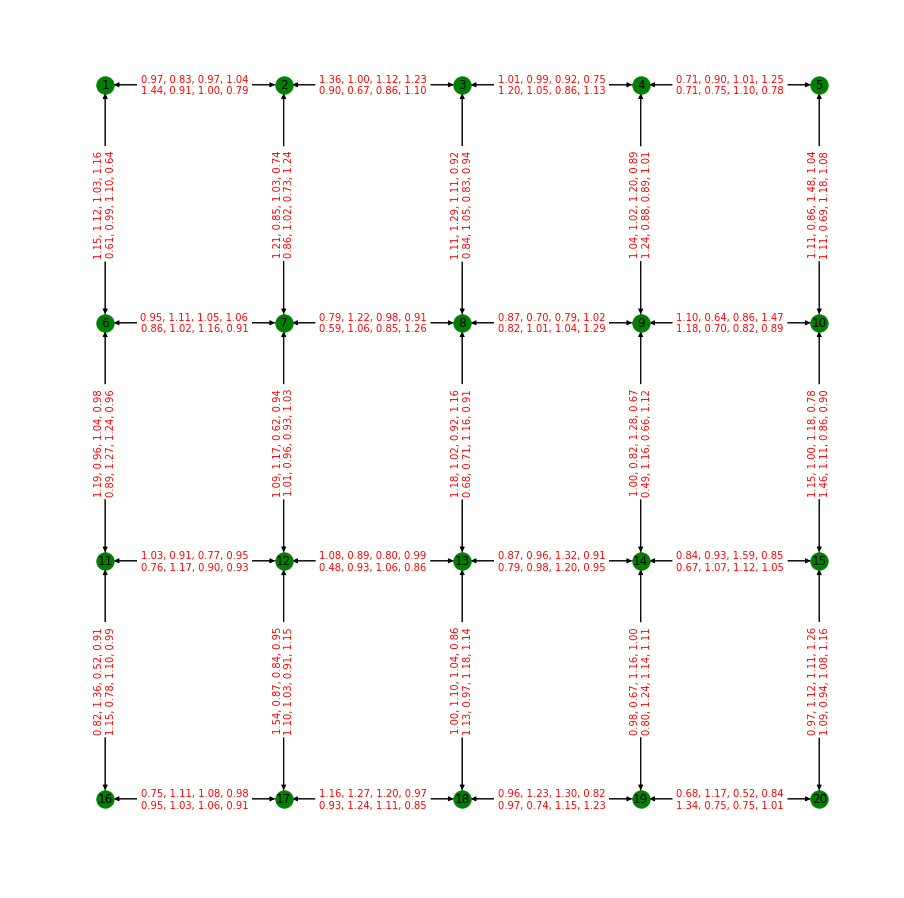

In [16]:
drawNetwork(G)